# Tutorial on convolution

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.ndimage.filters import correlate, convolve

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = [x for x in range(10)]

PyTorch expects images in the format (num_channels, width, height) while plt expects images in a numpy array of shape (width, height, num_channels). `np.transpose` takes as input an array and list of axes, and moves the original axes according to the order that appears in the list. For example, calling `transpose` with some image in the format (c,w,h) and the list (1,2,0) will return the array in the format (w,h,c).

Image shape:  torch.Size([1, 28, 28])
         1          7          7          6


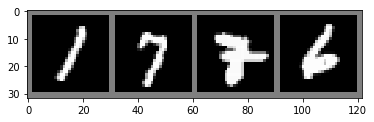

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

# Convolution

We will create a simple function, and use it to demonstrate the usage of convolution on images.

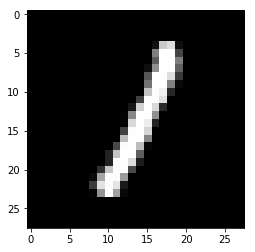

In [4]:
image = images[0].squeeze()
plt.imshow(image, cmap='gray')

In [5]:
top = np.asarray([[-1,-1,-1],
                  [ 1, 1, 1],
                  [ 0, 0, 0]]).T

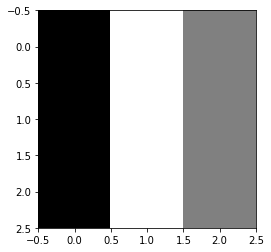

In [6]:
plt.imshow(top, cmap='gray')

Although convolution looks like a matrix, applying the convolution to some image is done by element-wise multiplication.

![image](images/conv.png)

Using python, applying a convolution filter is done by a simple function.

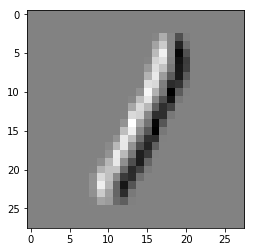

In [7]:
corr = correlate(image, top)
plt.imshow(corr, cmap='gray')

As you can see, this filter has highlighted the top edges. Try using different kernels to achieve different results.

In [8]:
identity = np.asarray([[ 0, 0, 0],
                       [ 0, 1, 0],
                       [ 0, 0, 0]])

edges1   = np.asarray([[ 0, 1, 0],
                       [ 1,-4, 1],
                       [ 0, 1, 0]])

edges2   = np.asarray([[-1,-1,-1],
                       [-1, 8,-1],
                       [-1,-1,-1]])

sharpen  = np.asarray([[ 0, -1, 0],
                       [ -1, 5,-1],
                       [ 0, -1, 0]])

blur = (1/9)*np.asarray([[ 1, 1, 1],
                         [ 1, 1, 1],
                         [ 1, 1, 1]])


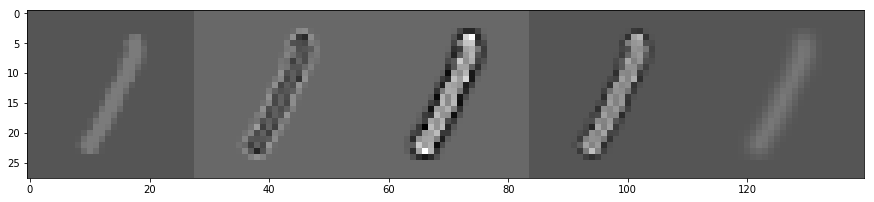

In [9]:
kernels = np.hstack([image, 
                     correlate(image, edges1),
                     correlate(image, edges2),
                     correlate(image, sharpen),
                     correlate(image, blur)])
plt.figure(figsize=(15,8))
plt.imshow(kernels, cmap='gray');

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[4, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[4, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %
